In [3]:
from numpy import (dtype, int8, float32, complex64)
from numpy import (arange, zeros, pi, sqrt, cos, sin, abs, log10, random, fft, transpose, argmax, resize)
from numpy import (real, imag)
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (14,7) # set figure size in notebook (needs to be ran twice to take effect)

# configuration parameters and signal scenario
FFT_LENGTH = 32            # transform size in pfb (a.k.a polyphase branches)
M = FFT_LENGTH             # polyphase branhces
P = 8                      # filter taps per polyphase branch
DEC_FACTOR = 24            # decimation rate, (D < M)
FINE_FFT_LENGTH = 512      # second stage transform size

fs = 10e3                  # simulation sample rate
fs_cs = fs/M               # critically sampled output sample rate
fs_os = fs/DEC_FACTOR      # oversampled output sample rate

OUTPUT_WINDOWS = 833       # number of output samples per polyphase branch after simulation
Nsamps = M*OUTPUT_WINDOWS  # number of generated data samples

t = Nsamps/fs              # simulation time duration

# 2nd stage channelizer parameters
hsov = (M-DEC_FACTOR)*FINE_FFT_LENGTH//(2*M)  # half-sided overlap, number of channels discared at one band edge
N_fine_channels = DEC_FACTOR*FINE_FFT_LENGTH  # Number of channels 2nd second stage (after discarding redundant channels)
offset = P-1   # wait P windows for valid outpts (filter wind up effect)


# generate frequency array for the signals of interest
unit_test = 1

# a single tone
if unit_test == 1:
    f_soi = [8641]

# tones centered at the bin center of the fine spectrum
if unit_test == 2:
    for m in range(0,FFT_LENGTH):
        subbins_full = np.arange(m*FINE_FFT_LENGTH, (m+1)*FINE_FFT_LENGTH) - ((FINE_FFT_LENGTH//2) + m*2*hsov)
        center_bin = subbins_full[FINE_FFT_LENGTH//2]
        f_soi.append(center_bin*fs_os/FINE_FFT_LENGTH)

# arbitrary length and listing of tones
if unit_test == 3:
    f_soi = [100, 250, 750, 1000, 1200, 1500, 2000, 2250,
            2400, 2750, 3250, 3500, 3800, 4000, 4500, 4750, 
            5100, 5250, 5750, 6000, 6400, 6500, 7000, 7250,
            7400, 7750, 8000, 8500, 8800, 9000, 9250, 9750]


# generate samples
signal_power = 20
noise_power = 10

signal_amp = sqrt(signal_power)
noise_amp = sqrt(noise_power/2)

n = arange(0, Nsamps)
x = zeros(Nsamps, dtype=complex64)

for f in f_soi:
    omega = 2*pi*f
    signal = signal_amp*(cos(omega*n/fs) + 1j*sin(omega*n/fs))
    x = x + signal

noise = noise_amp*(random.randn(Nsamps) + 1j*random.randn(Nsamps))
x = x + noise

x = x.astype(complex64)

# quantize
d_max = 127
d_min = -128
x_real = (real(x) - d_min)/(d_max-d_min) - 0.5
x_imag = (imag(x) - d_min)/(d_max-d_min) - 0.5 

x = x_real + 1j*x_imag

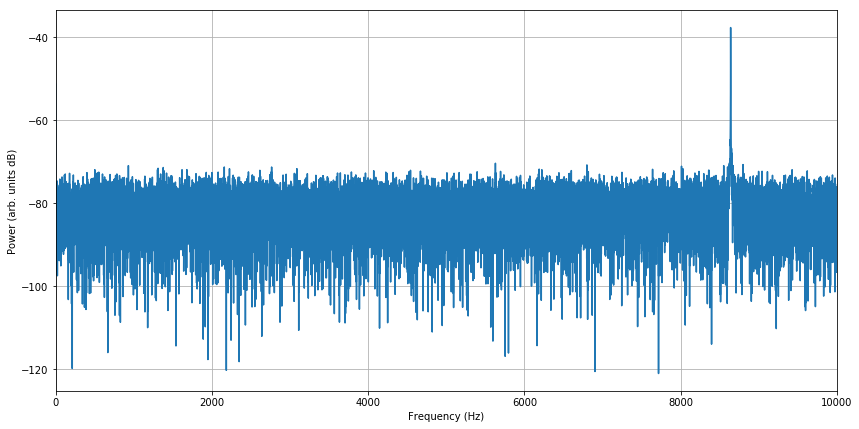

In [4]:
# plot a sample spectrum for verification of generated data
X = fft.fft(x, FFT_LENGTH*FINE_FFT_LENGTH)/(FFT_LENGTH*FINE_FFT_LENGTH)

fbins_pre = arange(0, FFT_LENGTH*FINE_FFT_LENGTH)
faxis_pre = fbins_pre*fs_cs/FINE_FFT_LENGTH

plt.plot(faxis_pre, 20*log10(abs(X)))
plt.xlim([min(faxis_pre), max(faxis_pre)])
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power (arb. units dB)')
plt.grid(); plt.show()

In [5]:
# initialize PYNQ, overlay, and data buffers
import pynq
from pynq import Xlnk
from pynq import Overlay

OVERLAY_PATH = '/home/xilinx/jupyter_notebooks/alpaca/overlay/pfb/mcb_os_pfb.bit'
overlay = Overlay(OVERLAY_PATH)
dma = overlay.axi_dma_0

xlnk = Xlnk()

in_buffer = xlnk.cma_array(shape=(DEC_FACTOR,), dtype=complex64, cacheable=1)
out_buffer = xlnk.cma_array(shape=(FFT_LENGTH,), dtype=complex64, cacheable=1)

ospfb_output = np.zeros(shape=(FFT_LENGTH, OUTPUT_WINDOWS), dtype=complex64)

def dma_transfer():
    dma.sendchannel.transfer(in_buffer)
    dma.recvchannel.transfer(out_buffer)
    dma.sendchannel.wait()
    dma.recvchannel.wait()

In [6]:
# Copy samples into input buffer shifting in DEC_FACTOR new samples each transfer
for window_idx in range(0, OUTPUT_WINDOWS):
    data_idx = window_idx*DEC_FACTOR
    np.copyto(in_buffer, x[data_idx:data_idx+DEC_FACTOR])
    dma_transfer()
    np.copyto(ospfb_output[:, window_idx], out_buffer)
    

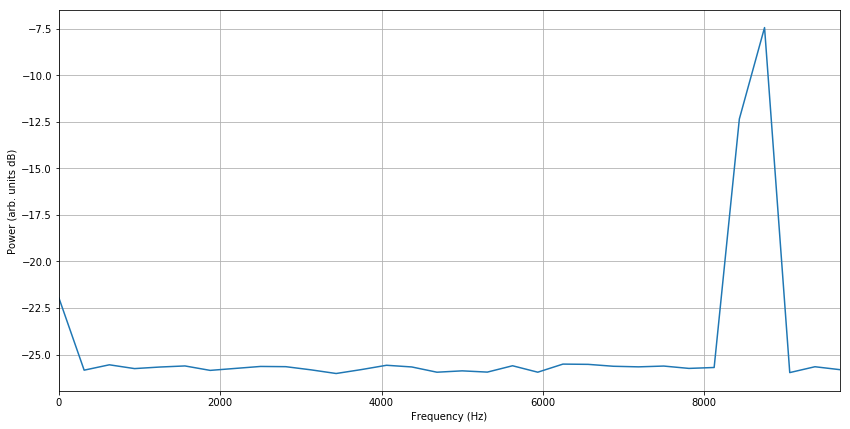

In [7]:
# plot coarse channel output
fbins = arange(0, FFT_LENGTH)
faxis = fbins*fs_cs

plt.plot(faxis, 20*log10(np.mean(abs(ospfb_output[:,offset:]),1)))
plt.xlim([min(faxis), max(faxis)])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (arb. units dB)')
plt.grid()
plt.show()

In [9]:
# second stage FFT fine spectrum output
fine_spectrum_matrix = fft.fftshift(fft.fft(ospfb_output[:, offset:(FINE_FFT_LENGTH+offset)],FINE_FFT_LENGTH, axis=1), axes=(1,))/FINE_FFT_LENGTH

# discard redundant channels
fine_spectrum = fine_spectrum_matrix[:, (hsov-1):-(hsov+1)]

# concatenate for full spectrum
fine_spectrum = fine_spectrum.reshape(N_fine_channels)

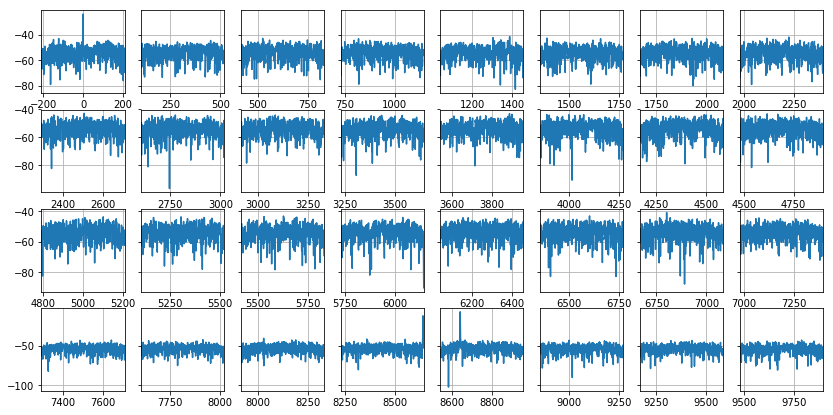

In [11]:
fig, ax = plt.subplots(4,8, sharey='row')
for i in range(0,4):
    for j in range(0,8):
        m = (i*8)+j
        # this shift corrects for overlap between adjacent bins 
        bin_shift = - ((FINE_FFT_LENGTH//2) + m*2*hsov)
        
        subbins = np.arange(m*FINE_FFT_LENGTH, (m+1)*FINE_FFT_LENGTH) + bin_shift
        cur_ax = ax[i,j]
        cur_ax.plot(subbins*fs_os/FINE_FFT_LENGTH, 20*log10(abs(fine_spectrum_matrix[m, :])))
        cur_ax.set_xlim(min(subbins*fs_os/FINE_FFT_LENGTH), max(subbins*fs_os/FINE_FFT_LENGTH))
        cur_ax.grid(True)
plt.show()

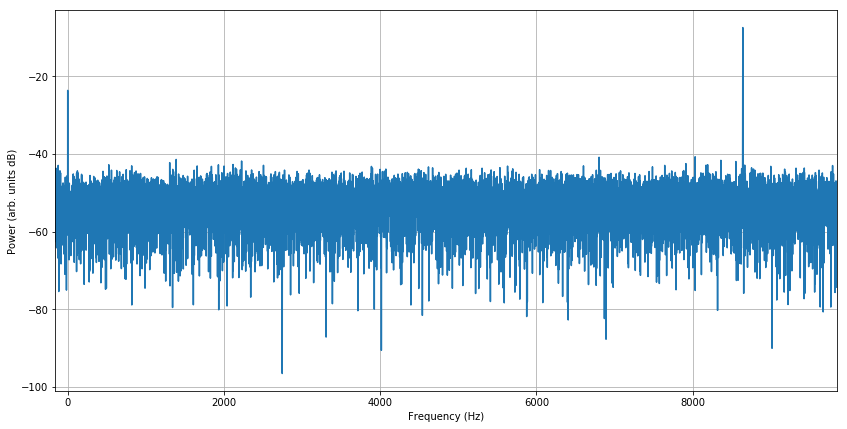

In [12]:
# plot fine spectrum
fshift = -(FINE_FFT_LENGTH/2-hsov+1)
fbins_fine = np.arange(0,N_fine_channels) + fshift
faxis_fine = fbins_fine*fs_os/FINE_FFT_LENGTH
plt.plot(faxis_fine, 20*log10(abs(fine_spectrum)))
plt.xlim([min(faxis_fine), max(faxis_fine)])
plt.xlabel('Frequency (Hz)'); plt.ylabel('Power (arb. units dB)')
plt.grid(); plt.show()